In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import time
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing, model_selection, pipeline
from sklearn.metrics import f1_score, roc_auc_score
from pathlib import Path
import sys


In [9]:
# get add the Base directory
BASE_DIR = str(Path().cwd().parent.resolve())
sys.path.insert(0, BASE_DIR)

In [12]:
df = pd.read_csv(f'{BASE_DIR}/data/fake_job_postings.csv', engine = 'python')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# 결측치

In [28]:
# 결측치 확인
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

False 데이터에서 결측치가 더 많은 것을 확인

결측치도 영향을 준다고 판단하여 결측치는 대체하여 진행

# 데이터 확인 및 분할

In [31]:
# 데이터 설명
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [32]:
# 텍스트 데이터 분할 및 결측치 대체
text_df = df.iloc[:, [1,5,6,7,8,17]]
text_df = text_df.fillna(' ')

text_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [33]:
# 범주형 데이터 분할 및 결측치 대체
cat_df = df.iloc[:, 9:18]
cat_df = cat_df.fillna('None')

cat_df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,Other,Internship,None,None,Marketing,0
1,0,1,0,Full-time,Not Applicable,None,Marketing and Advertising,Customer Service,0
2,0,1,0,None,None,None,None,None,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [34]:
# 범주형 데이터 label 확인 (industry, function은 양이 많아서 생략)
for col in cat_df.iloc[:,3:6].columns:
  print('{}: {}'.format(col, cat_df[col].unique()))

employment_type: ['Other' 'Full-time' 'None' 'Part-time' 'Contract' 'Temporary']
required_experience: ['Internship' 'Not Applicable' 'None' 'Mid-Senior level' 'Associate'
 'Entry level' 'Executive' 'Director']
required_education: ['None' "Bachelor's Degree" "Master's Degree" 'High School or equivalent'
 'Unspecified' 'Some College Coursework Completed' 'Vocational'
 'Certification' 'Associate Degree' 'Professional' 'Doctorate'
 'Some High School Coursework' 'Vocational - Degree'
 'Vocational - HS Diploma']


# Target variable

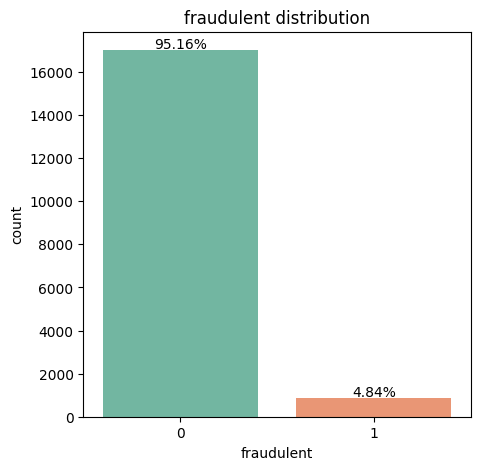

In [35]:
# fraudulent 변수 분포 확인
fig, ax = plt.subplots(1,1, figsize = (5,5))
sns.countplot(x = 'fraudulent', data = df)
plt.title('fraudulent distribution')
for p in ax.patches:
  ax.text(p.get_x() + p.get_width()/2., p.get_height() + 100, '{:1.2f}%'.format(p.get_height() / len(cat_df) * 100), ha = 'center')
plt.show()

In [36]:
 # False 비율
(df['fraudulent'] == 1).sum() / df.shape[0]

0.04843400447427293

False 비율이 4.8% 정도로 unbalance하다

# 범주형 데이터 label간 분포

In [37]:
# 범주형 데이터 플롯 함수
def cat_label_plot(col, data, r1=0, r2=0):
  plt.figure(figsize = (5,5))
  ax = plt.subplot(1,1,1)
  sns.set_palette('Set2')
  sns.countplot(x = col, data = data, hue = 'fraudulent')
  plt.title('{} distribution by fraudulent'.format(col))
  plt.setp(ax.xaxis.get_majorticklabels(), rotation = r1)
  size = []
  for p in ax.patches:
    h = p.get_height()
    size.append(h)
    w = p.get_width()
    x = p.get_x()
    ax.text(x + w/2, h + 5, '{:1.2f}%'.format(h/len(data)*100), ha = 'center', rotation = r2)
  plt.show()

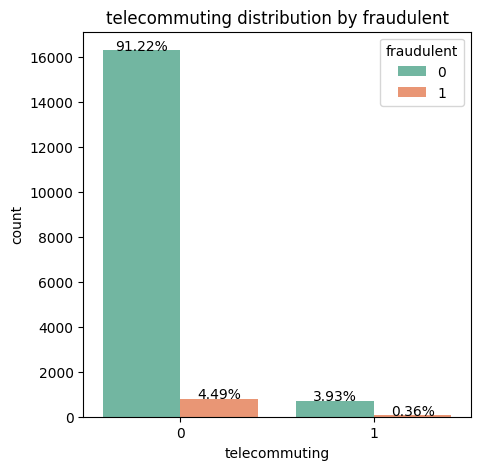

In [38]:
cat_label_plot('telecommuting', cat_df)

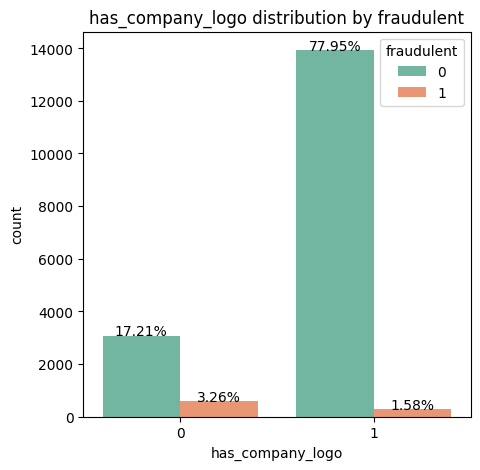

In [39]:
cat_label_plot('has_company_logo', cat_df)

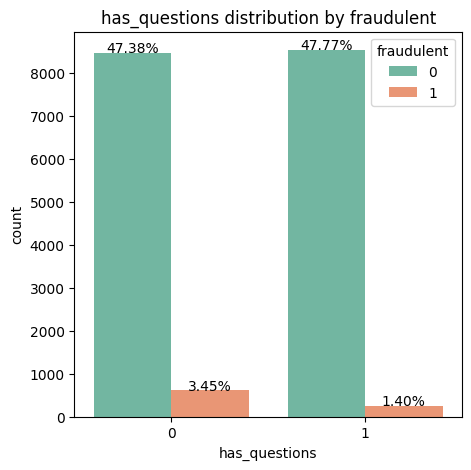

In [40]:
cat_label_plot('has_questions', cat_df)

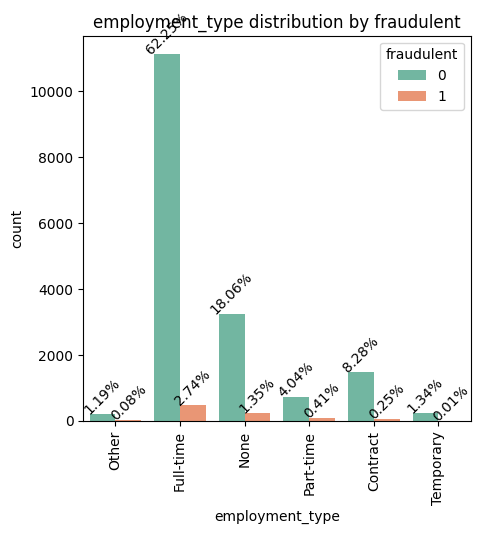

In [41]:
cat_label_plot('employment_type', cat_df, 90, 45)

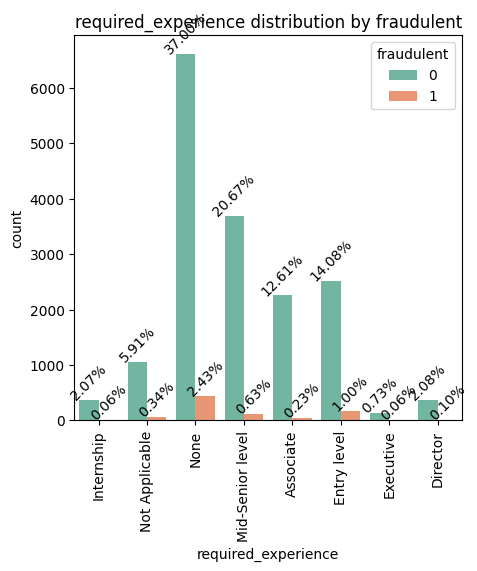

In [42]:
cat_label_plot('required_experience', cat_df, 90, 45)

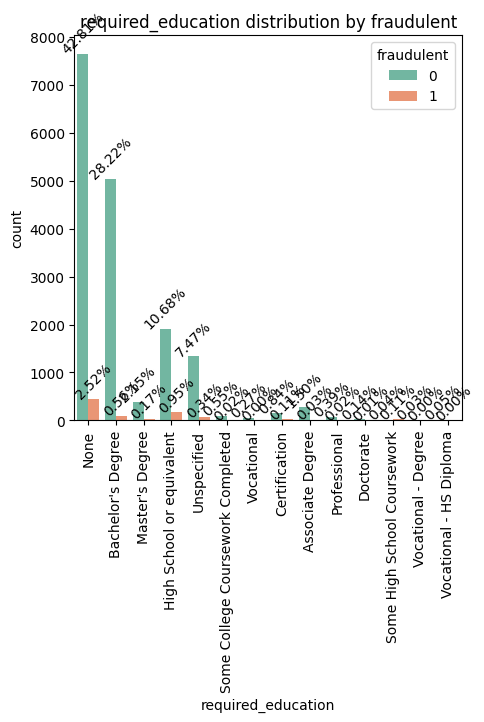

In [43]:
cat_label_plot('required_education', cat_df, 90, 45)

# 텍스트 데이터 label간 비교

In [44]:
# 텍스트 데이터 글자수 비교
def text_char_plot(col, data, nbins):
  fig = plt.figure(figsize = (5,5))
  ax = plt.subplot(1,1,1)
  len0 = data[data['fraudulent'] == 0][col].str.len()
  len1 = data[data['fraudulent'] == 1][col].str.len()
  max_n = max(max(len0), max(len1))
  bin_width = max_n / nbins
  bins = np.arange(0, max_n + bin_width, bin_width)
  sns.set_palette('Set2')
  ax.hist(len0, bins = bins, density = True, histtype = 'stepfilled', alpha = 0.5, label = 'True')
  ax.hist(len1, bins = bins, density = True, histtype = 'stepfilled', alpha = 0.5, label = 'Fake')
  plt.legend()
  plt.title('characters comparison in {}'.format(col))
  plt.show()

label간 비교를 위해 비율 히스토그램 사용

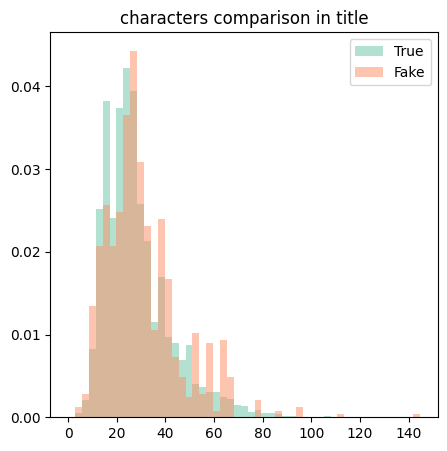

In [45]:
text_char_plot('title', text_df, 50)

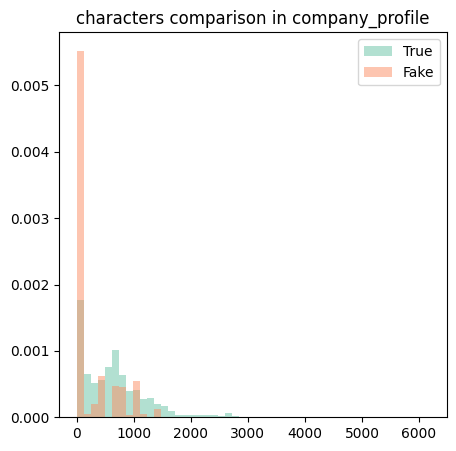

In [46]:
text_char_plot('company_profile', text_df, 50)

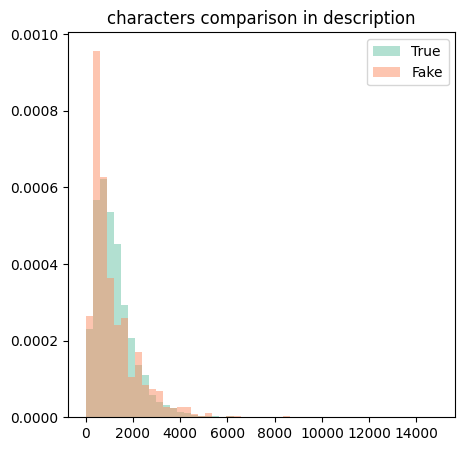

In [47]:
text_char_plot('description', text_df, 50)

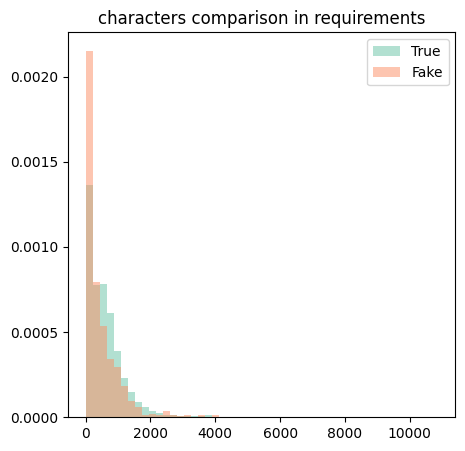

In [48]:
text_char_plot('requirements', text_df, 50)

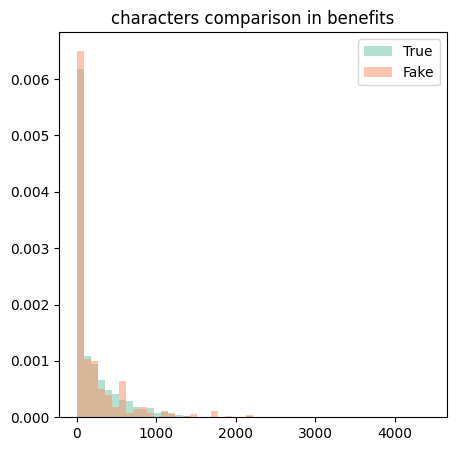

In [49]:
text_char_plot('benefits', text_df, 50)

In [50]:
# 텍스트 데이터 글자수 비교
def text_word_plot(col, data, nbins):
  fig = plt.figure(figsize = (5,5))
  ax = plt.subplot(1,1,1)
  len0 = data[data['fraudulent'] == 0][col].str.split().map(lambda x : len(x))
  len1 = data[data['fraudulent'] == 1][col].str.split().map(lambda x : len(x))
  max_n = max(max(len0), max(len1))
  bin_width = max_n / nbins
  bins = np.arange(0, max_n + bin_width, bin_width)
  sns.set_palette('Set2')
  ax.hist(len0, bins = bins, density = True, histtype = 'stepfilled', alpha = 0.5, label = 'True')
  ax.hist(len1, bins = bins, density = True, histtype = 'stepfilled', alpha = 0.5, label = 'Fake')
  plt.title('words comparison in {}'.format(col))
  plt.legend()
  plt.show()

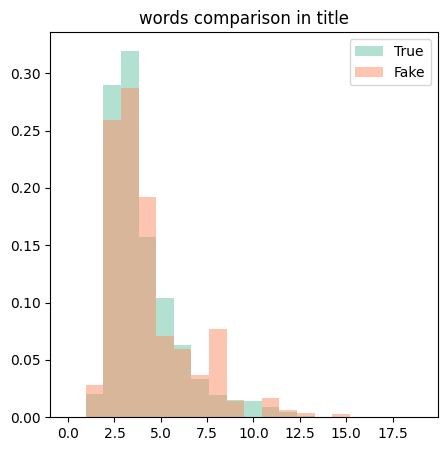

In [51]:
text_word_plot('title', text_df, 20)

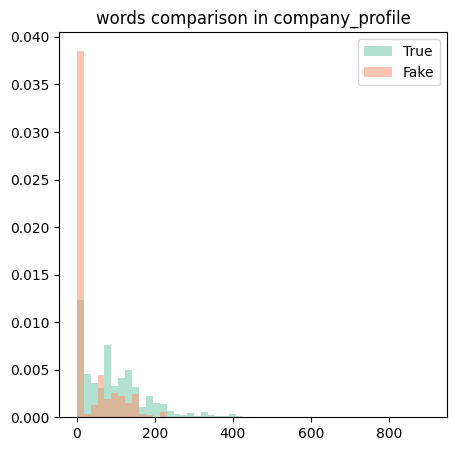

In [52]:
text_word_plot('company_profile', text_df, 50)

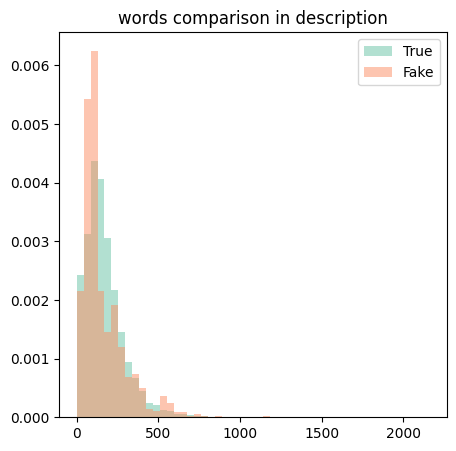

In [53]:
text_word_plot('description', text_df, 50)

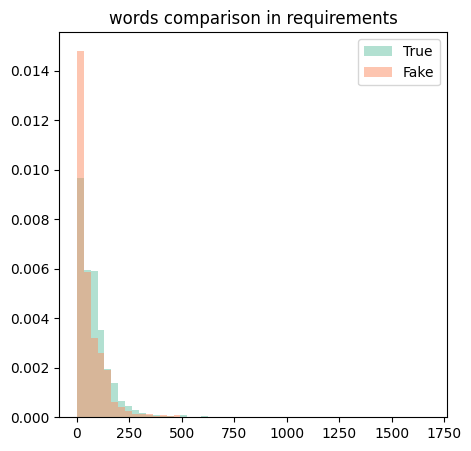

In [54]:
text_word_plot('requirements', text_df, 50)

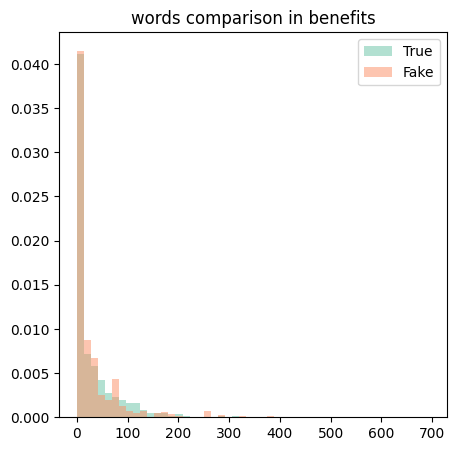

In [55]:
text_word_plot('benefits', text_df, 50)

# 텍스트 데이터 전처리

In [59]:
# 각 row의 모든 텍스트 concate
text = text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)), axis = 1)
target = df['fraudulent']

text.shape

(17880,)

In [60]:
# 텍스트 소문자화, []제거, 링크제거, 숫자 포함 제거
%%time
def clean_text(text):
  text = text.lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text

text = text.apply(lambda x: clean_text(x))
text.head()

CPU times: user 10.3 s, sys: 13.5 ms, total: 10.3 s
Wall time: 11.4 s


0    marketing internwere  and weve created a groun...
1    customer service  cloud video  seconds the wor...
2    commissioning machinery assistant cmavalor ser...
3    account executive  washington dcour passion fo...
4    bill review managerspotsource solutions llc is...
dtype: object

In [62]:
# 토큰화
%%time
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

text = text.apply(lambda x: tokenizer.tokenize(x))
text.head()

CPU times: user 3.38 s, sys: 600 ms, total: 3.98 s
Wall time: 4.04 s


0    [marketing, internwere, and, weve, created, a,...
1    [customer, service, cloud, video, seconds, the...
2    [commissioning, machinery, assistant, cmavalor...
3    [account, executive, washington, dcour, passio...
4    [bill, review, managerspotsource, solutions, l...
dtype: object

In [65]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [67]:
# 불용어 제거
%%time
stop_words = stopwords.words('english')
def remove_stopwords(text):
  words = [w for w in text if w not in stop_words]
  return words

text = text.apply(lambda x: remove_stopwords(x))
text.head()

CPU times: user 10 s, sys: 39.6 ms, total: 10.1 s
Wall time: 10.2 s


0    [marketing, internwere, weve, created, groundb...
1    [customer, service, cloud, video, seconds, wor...
2    [commissioning, machinery, assistant, cmavalor...
3    [account, executive, washington, dcour, passio...
4    [bill, review, managerspotsource, solutions, l...
dtype: object

In [68]:
# NGram 분석을 위해 하나의 텍스트로 변환
%%time
def combine_text(list_of_text):
  combined_text = ' '.join(list_of_text)
  return combined_text

text = text.apply(lambda x: combine_text(x))
text.head()

CPU times: user 189 ms, sys: 20.6 ms, total: 209 ms
Wall time: 220 ms


0    marketing internwere weve created groundbreaki...
1    customer service cloud video seconds worlds cl...
2    commissioning machinery assistant cmavalor ser...
3    account executive washington dcour passion imp...
4    bill review managerspotsource solutions llc gl...
dtype: object

# NGrams 분석